# Nevada EDA with the 2016 Presidential Election

Another State that we want to examine about the voter turnout and education is Nevada. We care about voter turnout variables, 2016 election outcome variables, and education-related variables in the state's dataset.

In [31]:
#import functions
from pyspark.sql.functions import col, countDistinct, round, when, translate, max, min, isnull, isnan, count

In [32]:
#import libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
# read in Nevada parquet file
bucket_dir = 'gs://pstat135-voter-file/VM2Uniform/'
NV_fulldf = spark.read.parquet(bucket_dir + 'VM2Uniform--NV--2021-06-13')

Below are the variables related to voter turnout, the outcome, and education within state of Nevada.

In [34]:
#limit the dataset to make it more efficient
keep = ['LALVOTERID', 'County', 'Board_of_Education_District', 'County_Board_of_Education_District', 'CommercialData_Education',
        'CommercialData_AreaMedianEducationYears', 'CommercialDataLL_Interest_in_Education_Online_In_Household',
        'ElectionReturns_G16_Cnty_Margin_Clinton_D', 'ElectionReturns_G16_Cnty_Percent_Clinton_D', 
        'ElectionReturns_G16_Cnty_Vote_Clinton_D', 'ElectionReturns_G16_Cnty_Margin_Trump_R',
        'ElectionReturns_G16_Cnty_Percent_Trump_R', 'ElectionReturns_G16_Cnty_Vote_Trump_R',
        'ElectionReturns_G16CountyTurnoutAllRegisteredVoters', 'ElectionReturns_G16CountyTurnoutDemocrats',
        'ElectionReturns_G16CountyTurnoutIndependentsAllOthers', 'ElectionReturns_G16CountyTurnoutRepublicans']
NV_df = NV_fulldf.select(keep)

In [5]:
# count number of distinct voter IDs
total_state_voters_NV = NV_df.select(countDistinct('LALVOTERID'))
total_state_voters_NV.show()

+--------------------------+
|count(DISTINCT LALVOTERID)|
+--------------------------+
|                   1866442|
+--------------------------+



<AxesSubplot:>

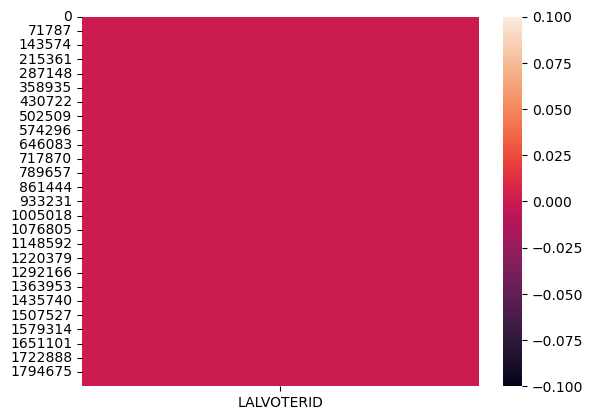

In [35]:
#check missing values
ID_list = NV_df.select('LALVOTERID')
ID_list_pd = ID_list.toPandas()
#convert values to binary T/F
ID_tf = ID_list_pd.isnull()
#plot heatmap
sns.heatmap(data = ID_tf)

In [7]:
#count distinct counties
num_counties_NV = NV_df.select(countDistinct('County'))
num_counties_NV.show()

+----------------------+
|count(DISTINCT County)|
+----------------------+
|                    17|
+----------------------+



<AxesSubplot:>

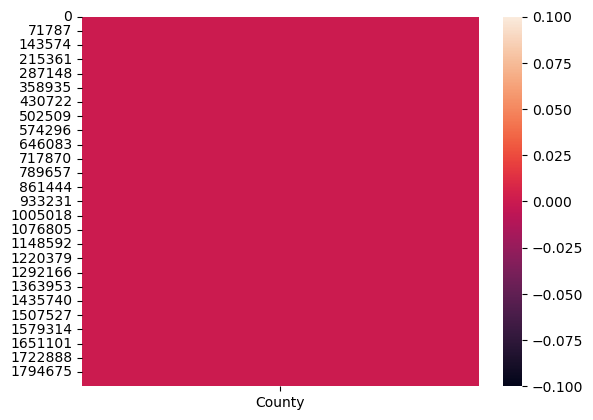

In [8]:
##check missing values
county_list = NV_df.select('County')
county_list_pd = county_list.toPandas()
#convert values to binary T/F
county_tf = county_list_pd.isnull()
#plot heatmap
sns.heatmap(data = county_tf)

# Exploring Voter Turnout 

After the basic exploration, we will take a look into columns with turnout of all kinds of votes for each Nevada county.

In [9]:
#voter turnout per county
NV_df = NV_df.withColumnRenamed("ElectionReturns_G16CountyTurnoutAllRegisteredVoters", "CountyTurnoutAll") \
    .withColumnRenamed("ElectionReturns_G16CountyTurnoutDemocrats", "CountyTurnoutDem") \
    .withColumnRenamed("ElectionReturns_G16CountyTurnoutIndependentsAllOthers", "CountyTurnoutOther") \
    .withColumnRenamed("ElectionReturns_G16CountyTurnoutRepublicans", "CountyTurnoutRep")
cty_voter_turnout_NV = NV_df.select('County', 'CountyTurnoutAll', 'CountyTurnoutDem',
                                'CountyTurnoutOther', 'CountyTurnoutRep').distinct().orderBy('County') # unique values per each county
cty_voter_turnout_NV.show()

+-----------+----------------+----------------+------------------+----------------+
|     County|CountyTurnoutAll|CountyTurnoutDem|CountyTurnoutOther|CountyTurnoutRep|
+-----------+----------------+----------------+------------------+----------------+
|CARSON CITY|             79%|             82%|               68%|             84%|
|  CHURCHILL|             74%|             75%|               63%|             79%|
|      CLARK|             65%|             68%|               53%|             74%|
|    DOUGLAS|             79%|             81%|               66%|             83%|
|       ELKO|             72%|             72%|               61%|             77%|
|  ESMERALDA|             72%|             68%|               61%|             77%|
|     EUREKA|             86%|             90%|               66%|             91%|
|   HUMBOLDT|             74%|             75%|               61%|             81%|
|     LANDER|             75%|             77%|               62%|          

Overall, the CountyTurnoutAll is pretty high, almost all the rate is higher than 70%. But the CountyTurnoutOther is relative low, around 50-60%. But the CountyTurnoutRe, the Republican voter turnout, is relatively than the CountyTurnoutDem.

In [10]:
#remove percentages and convert to integer
cty_voter_turnout_NV = cty_voter_turnout_NV.withColumn('CountyTurnoutPrcnt', translate(col('CountyTurnoutAll'),'%', ''))\
                    .withColumn('CountyTurnoutPrcntDem', translate(col('CountyTurnoutDem'),'%', ''))\
                    .withColumn('CountyTurnoutPrcntRep', translate(col('CountyTurnoutRep'),'%', ''))\
                    .withColumn('CountyTurnoutPrcntOther', translate(col('CountyTurnoutOther'),'%', ''))\
                    .drop('CountyTurnoutAll', 'CountyTurnoutDem', 'CountyTurnoutRep', 'CountyTurnoutOther')

from pyspark.sql.types import IntegerType
voter_turnout_NV_CLEAN = cty_voter_turnout_NV.withColumn('CountyTurnoutInt', cty_voter_turnout_NV['CountyTurnoutPrcnt'].cast(IntegerType()))\
                        .withColumn('CountyTurnoutDemInt', cty_voter_turnout_NV['CountyTurnoutPrcntDem'].cast(IntegerType()))\
                        .withColumn('CountyTurnoutRepInt', cty_voter_turnout_NV['CountyTurnoutPrcntRep'].cast(IntegerType()))\
                        .withColumn('CountyTurnoutOtherInt', cty_voter_turnout_NV['CountyTurnoutPrcntOther'].cast(IntegerType()))\
                        .drop('CountyTurnoutPrcnt', 'CountyTurnoutPrcntDem', 'CountyTurnoutPrcntRep', 'CountyTurnoutPrcntOther')
voter_turnout_NV_CLEAN.show()

+-----------+----------------+-------------------+-------------------+---------------------+
|     County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+-----------+----------------+-------------------+-------------------+---------------------+
|CARSON CITY|              79|                 82|                 84|                   68|
|  CHURCHILL|              74|                 75|                 79|                   63|
|      CLARK|              65|                 68|                 74|                   53|
|    DOUGLAS|              79|                 81|                 83|                   66|
|       ELKO|              72|                 72|                 77|                   61|
|  ESMERALDA|              72|                 68|                 77|                   61|
|     EUREKA|              86|                 90|                 91|                   66|
|   HUMBOLDT|              74|                 75|                 81|

We want to examine the maximum and minimum voter turnout rates across all the categories to find the counties with extremes.

In [36]:
#max and min across all the categories
voter_turnout_NV_CLEAN.select(max('CountyTurnoutInt'), max('CountyTurnoutDemInt'), max('CountyTurnoutRepInt'), max('CountyTurnoutOtherInt')).show()
voter_turnout_NV_CLEAN.select(min('CountyTurnoutInt'), min('CountyTurnoutDemInt'), min('CountyTurnoutRepInt'), min('CountyTurnoutOtherInt')).show()

+---------------------+------------------------+------------------------+--------------------------+
|max(CountyTurnoutInt)|max(CountyTurnoutDemInt)|max(CountyTurnoutRepInt)|max(CountyTurnoutOtherInt)|
+---------------------+------------------------+------------------------+--------------------------+
|                   86|                      90|                      91|                        74|
+---------------------+------------------------+------------------------+--------------------------+



+---------------------+------------------------+------------------------+--------------------------+
|min(CountyTurnoutInt)|min(CountyTurnoutDemInt)|min(CountyTurnoutRepInt)|min(CountyTurnoutOtherInt)|
+---------------------+------------------------+------------------------+--------------------------+
|                   65|                      65|                      69|                        53|
+---------------------+------------------------+------------------------+--------------------------+



In [37]:
#find counties with max and min for all turnout
NV_turnout_max_min = voter_turnout_NV_CLEAN.filter((col('CountyTurnoutInt')==86) | (col('CountyTurnoutInt')==65))
NV_turnout_max_min.show()

+------+----------------+-------------------+-------------------+---------------------+
|County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+------+----------------+-------------------+-------------------+---------------------+
| CLARK|              65|                 68|                 74|                   53|
|EUREKA|              86|                 90|                 91|                   66|
|   NYE|              65|                 65|                 72|                   55|
+------+----------------+-------------------+-------------------+---------------------+



The Nevada county EUREKA has the highest turnout rate, and CLARK and NYE have lowest turnout rate

In [38]:
# find counties w min and max for dem turnout
NV_dem_turnout_max_min = voter_turnout_NV_CLEAN.filter((col('CountyTurnoutDemInt')==90) | (col('CountyTurnoutDemInt')==65))
NV_dem_turnout_max_min.show()

+------+----------------+-------------------+-------------------+---------------------+
|County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+------+----------------+-------------------+-------------------+---------------------+
|EUREKA|              86|                 90|                 91|                   66|
|   NYE|              65|                 65|                 72|                   55|
+------+----------------+-------------------+-------------------+---------------------+



The Nevada county EUREKA has the highest democrat turnout rate, and NYE have lowest democrat turnout rate

In [39]:
# find counties w min and max for rep turnout
NV_rep_turnout_max_min = voter_turnout_NV_CLEAN.filter((col('CountyTurnoutRepInt')==91) | (col('CountyTurnoutRepInt')==69))
NV_rep_turnout_max_min.show()
#NV_rep_turnout_max_min.filter(col('CountyTurnoutRepInt')==91).count()

+-------+----------------+-------------------+-------------------+---------------------+
| County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+-------+----------------+-------------------+-------------------+---------------------+
| EUREKA|              86|                 90|                 91|                   66|
|MINERAL|              66|                 70|                 69|                   53|
+-------+----------------+-------------------+-------------------+---------------------+



1

The Nevada county EUREKA has the highest Republican turnout rate, and MINERAL have lowest Republican turnout rate

In [40]:
NV_other_turnout_max_min = voter_turnout_NV_CLEAN.filter((col('CountyTurnoutOtherInt')==74) | (col('CountyTurnoutOtherInt')==53))
NV_other_turnout_max_min.show()

+-------+----------------+-------------------+-------------------+---------------------+
| County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+-------+----------------+-------------------+-------------------+---------------------+
|  CLARK|              65|                 68|                 74|                   53|
|MINERAL|              66|                 70|                 69|                   53|
| STOREY|              84|                 88|                 88|                   74|
+-------+----------------+-------------------+-------------------+---------------------+



The Nevada county STOREY has the highest Independent/Other turnout rate, and MINERAL and CLARK have lowest Independent/Other turnout rate

Overall, Nevada has high Democrat turnover rate. This finding can implicate the situation of how active of Democrat in Nevada state.

# Exploring the 2016 General Election Outcome in Nevada

Now we can take a deeper look at the outcome variables like the proportion of votes for each Nevada county. 

In [16]:
#show election data per county
NV_df = NV_df.withColumnRenamed("ElectionReturns_G16_Cnty_Percent_Clinton_D", "Cnty_Percent_D") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Vote_Clinton_D", "Cnty_Vote_D") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Percent_Trump_R", "Cnty_Percent_R") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Vote_Trump_R", "Cnty_Vote_R")
election_results_NV = NV_df.select('County',
                                   'Cnty_Percent_D', 
                                   'Cnty_Vote_D',
                                   'Cnty_Percent_R', 
                                   'Cnty_Vote_R').distinct().orderBy('County')
election_results_NV.show()

+-----------+--------------+-----------+--------------+-----------+
|     County|Cnty_Percent_D|Cnty_Vote_D|Cnty_Percent_R|Cnty_Vote_R|
+-----------+--------------+-----------+--------------+-----------+
|CARSON CITY|           38%|       9610|           52%|      13125|
|  CHURCHILL|           20%|       2210|           72%|       7830|
|      CLARK|           52%|     402227|           42%|     320057|
|    DOUGLAS|           30%|       8454|           62%|      17415|
|       ELKO|           18%|       3401|           73%|      13551|
|  ESMERALDA|           15%|         65|           78%|        329|
|     EUREKA|            9%|         74|           85%|        723|
|   HUMBOLDT|           22%|       1386|           70%|       4521|
|     LANDER|           17%|        403|           76%|       1828|
|    LINCOLN|           13%|        285|           78%|       1671|
|       LYON|           26%|       6146|           67%|      16005|
|    MINERAL|           32%|        637|        

We can see some counties has a significant preference, some have similar results. For example, the  EUREKA county has a strong preference towards the Republican. For WASHOE, it has similar vote turnover.

In [17]:
# remove percentages and convert to integer values 
election_results_NV = election_results_NV.withColumn('Cnty_Prcnt_D', translate(col('Cnty_Percent_D'),'%', ''))\
                    .withColumn('Cnty_Prcnt_R', translate(col('Cnty_Percent_R'),'%', ''))\
                    .drop('Cnty_Percent_D', 'Cnty_Percent_R')

election_results_NV_CLEAN = election_results_NV.withColumn('Cnty_Prcnt_D_Int', election_results_NV['Cnty_Prcnt_D'].cast(IntegerType()))\
                        .withColumn('Cnty_Prcnt_R_Int', election_results_NV['Cnty_Prcnt_R'].cast(IntegerType()))\
                        .withColumn('Cnty_Vote_D_Int', election_results_NV['Cnty_Vote_D'].cast(IntegerType()))\
                        .withColumn('Cnty_Vote_R_Int', election_results_NV['Cnty_Vote_R'].cast(IntegerType()))\
                        .drop('Cnty_Prcnt_D', 'Cnty_Prcnt_R', 'Cnty_Vote_D', 'Cnty_Vote_R')
election_results_NV_CLEAN.show()

+-----------+----------------+----------------+---------------+---------------+
|     County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+-----------+----------------+----------------+---------------+---------------+
|CARSON CITY|              38|              52|           9610|          13125|
|  CHURCHILL|              20|              72|           2210|           7830|
|      CLARK|              52|              42|         402227|         320057|
|    DOUGLAS|              30|              62|           8454|          17415|
|       ELKO|              18|              73|           3401|          13551|
|  ESMERALDA|              15|              78|             65|            329|
|     EUREKA|               9|              85|             74|            723|
|   HUMBOLDT|              22|              70|           1386|           4521|
|     LANDER|              17|              76|            403|           1828|
|    LINCOLN|              13|          

In [44]:
# count how many counties D got the majority vote in
election_results_NV_CLEAN.filter(col('Cnty_Prcnt_D_Int')>col('Cnty_Prcnt_R_Int')).count()

2

In [46]:
# count how many counties R got the majority vote in
election_results_NV_CLEAN.filter(col('Cnty_Prcnt_D_Int')<col('Cnty_Prcnt_R_Int')).count()

15

The Democrat presidential candidate won the majority of votes of 2 counties, while the Republic won the 15 counties. 

In [18]:
# show max and min for Prcnt of D and R
election_results_NV_CLEAN.select(max('Cnty_Prcnt_D_Int'), max('Cnty_Prcnt_R_Int')).show()
election_results_NV_CLEAN.select(min('Cnty_Prcnt_D_Int'), min('Cnty_Prcnt_R_Int')).show()

+---------------------+---------------------+
|max(Cnty_Prcnt_D_Int)|max(Cnty_Prcnt_R_Int)|
+---------------------+---------------------+
|                   52|                   85|
+---------------------+---------------------+



+---------------------+---------------------+
|min(Cnty_Prcnt_D_Int)|min(Cnty_Prcnt_R_Int)|
+---------------------+---------------------+
|                    9|                   42|
+---------------------+---------------------+



In [42]:
#show the max and min county information
NV_D_Prcnt_max_min = election_results_NV_CLEAN.filter((col('Cnty_Prcnt_D_Int')==52) | (col('Cnty_Prcnt_D_Int')==9))
NV_D_Prcnt_max_min.show()
NV_R_Prcnt_max_min = election_results_NV_CLEAN.filter((col('Cnty_Prcnt_R_Int')==85) | (col('Cnty_Prcnt_R_Int')==42))
NV_R_Prcnt_max_min.show()

+------+----------------+----------------+---------------+---------------+
|County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+------+----------------+----------------+---------------+---------------+
| CLARK|              52|              42|         402227|         320057|
|EUREKA|               9|              85|             74|            723|
+------+----------------+----------------+---------------+---------------+



+------+----------------+----------------+---------------+---------------+
|County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+------+----------------+----------------+---------------+---------------+
| CLARK|              52|              42|         402227|         320057|
|EUREKA|               9|              85|             74|            723|
+------+----------------+----------------+---------------+---------------+



CLARK has the highest Democrat rate while EUREKA has the lowerest Democrat rate.

# Exploring Median Education Years by County

In order to find the relationship between education and voter turnout/outcomes, we will examine the education variables with vote rates. 

<AxesSubplot:ylabel='County'>

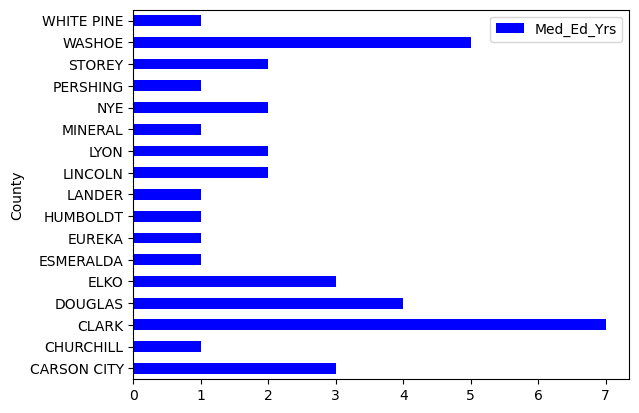

In [20]:
#histogram for the median education per county
NV_df = NV_df.withColumnRenamed('CommercialData_AreaMedianEducationYears', 'Med_Ed_Yrs')
ed_yrs_by_cty_NV = NV_df.groupBy('County').agg(countDistinct('Med_Ed_Yrs')).orderBy('County')
ed_yrs_by_cty_NV = ed_yrs_by_cty_NV.withColumn('Med_Ed_Yrs', col('count(Med_Ed_Yrs)')).drop(col('count(Med_Ed_Yrs)'))
ed_yrs_by_cty_pd_NV = ed_yrs_by_cty_NV.toPandas()
ed_yrs_by_cty_pd_NV.plot(kind='barh', x='County', y='Med_Ed_Yrs', color='blue')

In [21]:
#count the counties for each value
ed_yrs_by_cty_cnt_NV = ed_yrs_by_cty_NV.groupBy('Med_Ed_Yrs').agg(countDistinct('County')).orderBy('Med_Ed_Yrs')
ed_yrs_by_cty_cnt_NV.show()

+----------+-------------+
|Med_Ed_Yrs|count(County)|
+----------+-------------+
|         1|            8|
|         2|            4|
|         3|            2|
|         4|            1|
|         5|            1|
|         7|            1|
+----------+-------------+



The mode of median year of education is 1 year. The max is 7 years, and only Clark county has that max. The min is 1, which is the same as the mode.

In [49]:
ed_yr_turnout_NV = ed_yrs_by_cty_NV.join(voter_turnout_NV_CLEAN, 'County').orderBy('Med_Ed_Yrs').show()

+-----------+----------+----------------+-------------------+-------------------+---------------------+
|     County|Med_Ed_Yrs|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+-----------+----------+----------------+-------------------+-------------------+---------------------+
|    MINERAL|         1|              66|                 70|                 69|                   53|
| WHITE PINE|         1|              76|                 83|                 80|                   62|
|  CHURCHILL|         1|              74|                 75|                 79|                   63|
|     LANDER|         1|              75|                 77|                 80|                   62|
|   HUMBOLDT|         1|              74|                 75|                 81|                   61|
|  ESMERALDA|         1|              72|                 68|                 77|                   61|
|   PERSHING|         1|              74|                 75|   

CLARK with highest median education year, has higher republic turnout rate. But there is no huge difference for different median education years between Dem and Rep turnout rate. But the overall turnout rate is a bit higher for the Republic.

# Explore Education Level by County

We want to have a deeper understanding of how the education level relates to the turnover rate in the state of Nevada

In [47]:
#clean education data
ed_lvl_combine = when(NV_df.CommercialData_Education.like('Grad Degree%'), 'Grad Degree')\
                .when(NV_df.CommercialData_Education.like('Bach Degree%'), 'Bach Degree')\
                .when(NV_df.CommercialData_Education.like('Vocational Technical Degree%'), 'Vocational Technical Degree')\
                .when(NV_df.CommercialData_Education.like('Some College%'), 'Some College')\
                .when(NV_df.CommercialData_Education.like('HS Diploma%'), 'HS Diploma')\
                .when(NV_df.CommercialData_Education.like('Less than HS Diploma%'), 'Less Than HS Diploma')\
                .otherwise('Null')
NV_df = NV_df.withColumn("Education_Lvl", ed_lvl_combine)

In [48]:
#count and percentages of each education level
total_state_voters_NV = NV_df.select('LALVOTERID').count()
print('The total number of voters in the state of Nevada:', total_state_voters_NV)

ed_lvl_st_cnt_NV = NV_df.groupBy(['Education_Lvl']).agg(countDistinct('LALVOTERID'))
ed_lvl_st_cnt_NV = ed_lvl_st_cnt_NV.withColumnRenamed('count(LALVOTERID)', 'num_voters')
ed_lvl_state_NV = ed_lvl_st_cnt_NV.withColumn('prcnt_of_total', round(((col('num_voters')/total_state_voters_NV)*100), 2))
ed_lvl_state_NV.show()

The total number of voters in the state of Nevada: 1866442


+--------------------+----------+--------------+
|       Education_Lvl|num_voters|prcnt_of_total|
+--------------------+----------+--------------+
|Less Than HS Diploma|     55265|          2.96|
|          HS Diploma|    273705|         14.66|
|         Bach Degree|    241777|         12.95|
|         Grad Degree|    119265|          6.39|
|Vocational Techni...|      1483|          0.08|
|        Some College|    281869|          15.1|
|                Null|    893078|         47.85|
+--------------------+----------+--------------+



<AxesSubplot:ylabel='Education_Lvl'>

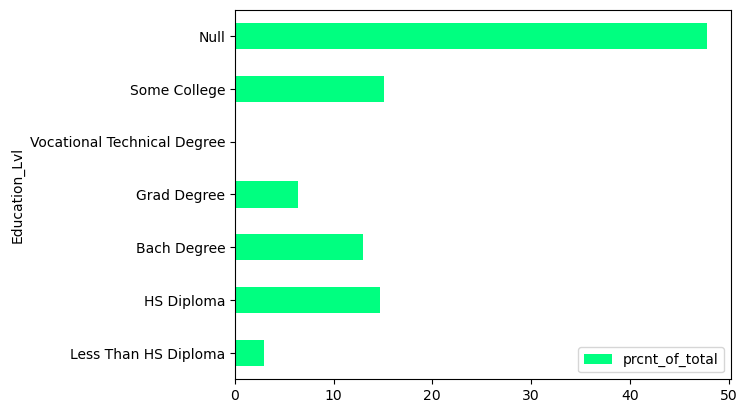

In [25]:
#histogram
ed_lvl_state_pd_NV = ed_lvl_state_NV.toPandas()
ed_lvl_state_pd_NV.plot(kind='barh', x='Education_Lvl', y='prcnt_of_total', colormap='winter_r')

A majority of Nevada voters have a null value, the next majority is some college, while the lowest is Vocational Technical Degree. 

We can dive into different education level and county, and get the percentage and total number

In [26]:
# find the counts and percentage of each level of educatoin for each county in the state
county_voters_NV = NV_df.groupBy('County').agg(countDistinct('LALVOTERID'))
county_voters_NV = county_voters_NV.withColumn("voter_total", col('count(LALVOTERID)')).drop(col('count(LALVOTERID)')) 

ed_lvl_county_cnt_NV = NV_df.groupBy(['County','Education_Lvl']).agg(countDistinct('LALVOTERID'))
ed_lvl_county_cnt_NV = ed_lvl_county_cnt_NV.withColumn("ed_level_total", col('count(LALVOTERID)')).drop(col('count(LALVOTERID)')) 
ed_lvl_by_county_NV = ed_lvl_county_cnt_NV.join(county_voters_NV, 'County').orderBy('County')
ed_lvl_by_county_NV = ed_lvl_by_county_NV.withColumn("prcnt_of_total", round(((col("ed_level_total")/col("voter_total"))*100), 2))
ed_lvl_by_county_NV.show()

+-----------+--------------------+--------------+-----------+--------------+
|     County|       Education_Lvl|ed_level_total|voter_total|prcnt_of_total|
+-----------+--------------------+--------------+-----------+--------------+
|CARSON CITY|         Bach Degree|          4922|      36026|         13.66|
|CARSON CITY|          HS Diploma|          5687|      36026|         15.79|
|CARSON CITY|                Null|         15394|      36026|         42.73|
|CARSON CITY|        Some College|          6157|      36026|         17.09|
|CARSON CITY|         Grad Degree|          2708|      36026|          7.52|
|CARSON CITY|Less Than HS Diploma|          1129|      36026|          3.13|
|CARSON CITY|Vocational Techni...|            29|      36026|          0.08|
|  CHURCHILL|Vocational Techni...|            47|      15837|           0.3|
|  CHURCHILL|                Null|          6067|      15837|         38.31|
|  CHURCHILL|          HS Diploma|          3310|      15837|          20.9|

<AxesSubplot:title={'center':'Null Values'}, ylabel='County'>

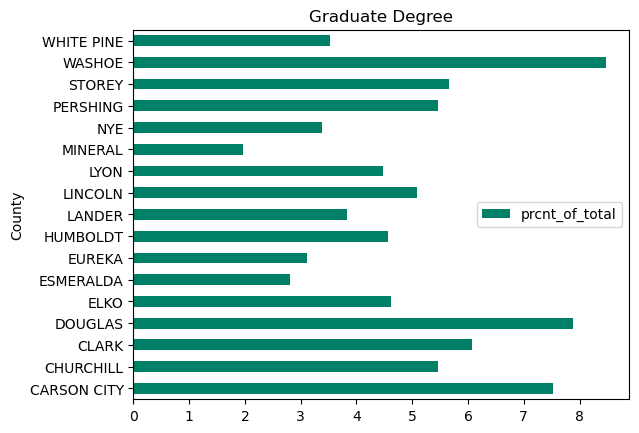

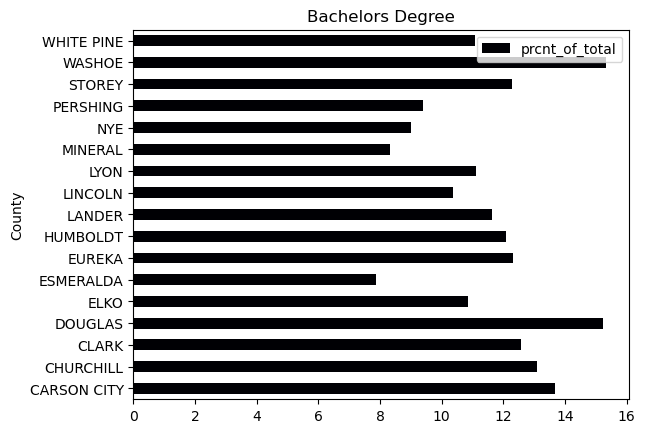

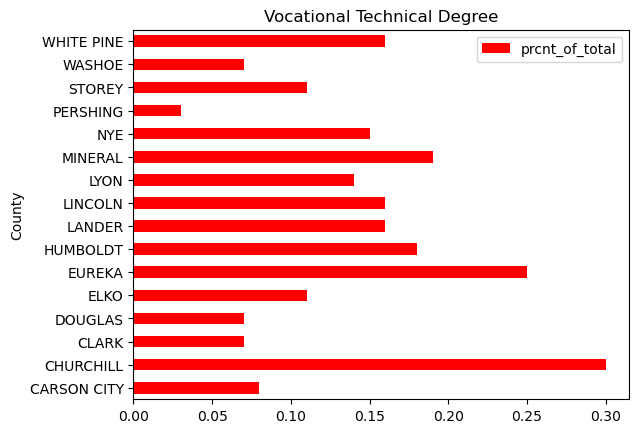

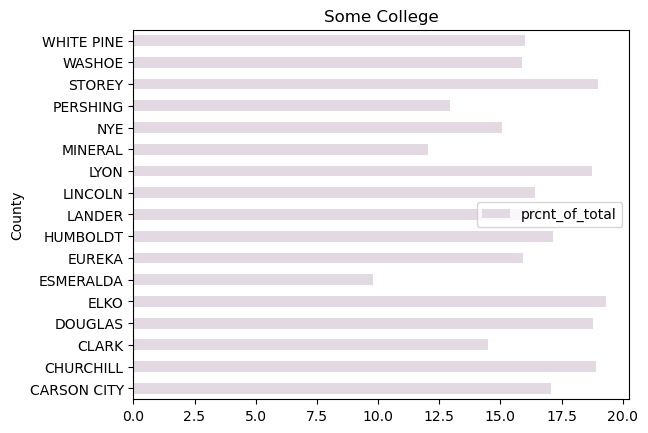

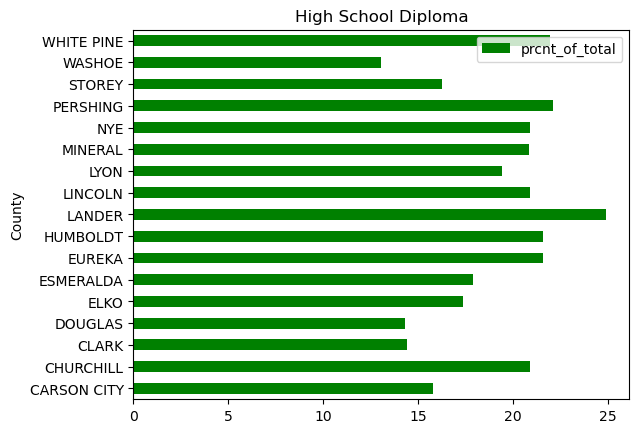

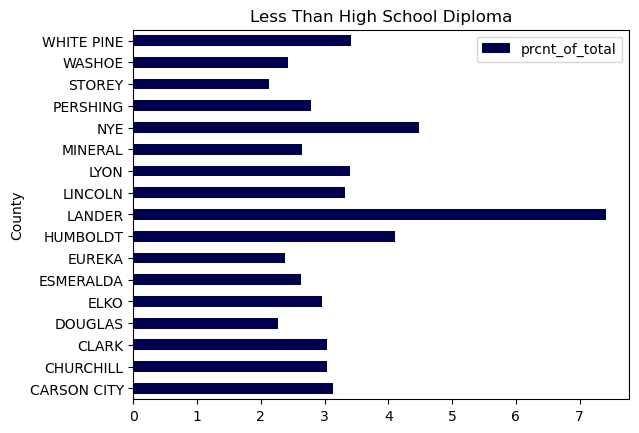

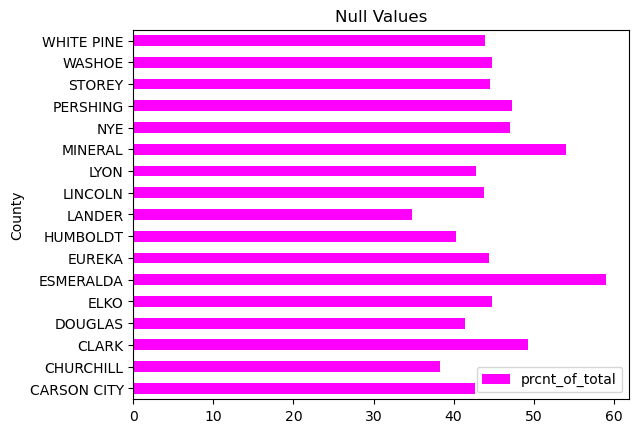

In [27]:
## visualize distribution across counties for each level of education

## distribution of grad degrees per county
grad_dgs_by_county_NV = ed_lvl_by_county_NV.filter(ed_lvl_by_county_NV.Education_Lvl == "Grad Degree")
grad_dgs_by_county_pd_NV = grad_dgs_by_county_NV.toPandas()
grad_dgs_by_county_pd_NV.plot.barh(x='County', y='prcnt_of_total', colormap='summer', title='Graduate Degree')

## distribution of bach degrees per county
bach_dgs_by_county_NV = ed_lvl_by_county_NV.filter(ed_lvl_by_county_NV.Education_Lvl == "Bach Degree")
bach_dgs_by_county_pd_NV = bach_dgs_by_county_NV.toPandas()
bach_dgs_by_county_pd_NV.plot.barh(x='County', y='prcnt_of_total', colormap='magma', title='Bachelors Degree')

## distribution of vocational technical degrees per county
voc_dgs_by_county_NV = ed_lvl_by_county_NV.filter(ed_lvl_by_county_NV.Education_Lvl == "Vocational Technical Degree")
voc_dgs_by_county_pd_NV = voc_dgs_by_county_NV.toPandas()
voc_dgs_by_county_pd_NV.plot.barh(x='County', y='prcnt_of_total', colormap='autumn', title='Vocational Technical Degree')

## distribution of some college per county
some_col_by_county_NV = ed_lvl_by_county_NV.filter(ed_lvl_by_county_NV.Education_Lvl == "Some College")
some_col_by_county_pd_NV = some_col_by_county_NV.toPandas()
some_col_by_county_pd_NV.plot.barh(x='County', y='prcnt_of_total', colormap='twilight', title='Some College')
## distribution of hs diploma per county
hs_dip_by_county_NV = ed_lvl_by_county_NV.filter(ed_lvl_by_county_NV.Education_Lvl == "HS Diploma")
hs_dip_by_county_pd_NV = hs_dip_by_county_NV.toPandas()
hs_dip_by_county_pd_NV.plot.barh(x='County', y='prcnt_of_total', colormap='ocean', title='High School Diploma')

## distribution of less than hs diploma per county
less_thn_hs_by_county_NV = ed_lvl_by_county_NV.filter(ed_lvl_by_county_NV.Education_Lvl == "Less Than HS Diploma")
less_thn_hs_by_county_pd_NV = less_thn_hs_by_county_NV.toPandas()
less_thn_hs_by_county_pd_NV.plot.barh(x='County', y='prcnt_of_total', colormap='seismic', title='Less Than High School Diploma')

## distribution of null education level per county
null_ed_lvl_by_county_NV = ed_lvl_by_county_NV.filter(ed_lvl_by_county_NV.Education_Lvl == "Null")
null_ed_lvl_by_county_pd_NV = null_ed_lvl_by_county_NV.toPandas()
null_ed_lvl_by_county_pd_NV.plot.barh(x='County', y='prcnt_of_total', colormap='spring', title='Null Values')

In [50]:
# comparing voter turnout vs. education level by county
ed_lvl_turnout_NV = ed_lvl_by_county_NV.join(voter_turnout_NV_CLEAN, 'County').orderBy('County', 'Education_Lvl')
# comparing voter turnout and election outcome vs. education level by county
ed_lvl_turnout_outcome_NV = ed_lvl_turnout_NV.join(election_results_NV_CLEAN, 'County').orderBy('County', 'Education_Lvl')

In [51]:
# find min and max values for proportion of voters in education level
ed_lvl_turnout_outcome_NV.filter(col('Education_Lvl') == "Grad Degree").select(max('prcnt_of_total'), min('prcnt_of_total')).show()
ed_lvl_turnout_outcome_NV.filter(col('Education_Lvl') == "Bach Degree").select(max('prcnt_of_total'), min('prcnt_of_total')).show()
ed_lvl_turnout_outcome_NV.filter(col('Education_Lvl') == "Some College").select(max('prcnt_of_total'), min('prcnt_of_total')).show()
ed_lvl_turnout_outcome_NV.filter(col('Education_Lvl') == "HS Diploma").select(max('prcnt_of_total'), min('prcnt_of_total')).show()

+-------------------+-------------------+
|max(prcnt_of_total)|min(prcnt_of_total)|
+-------------------+-------------------+
|               8.47|               1.96|
+-------------------+-------------------+



+-------------------+-------------------+
|max(prcnt_of_total)|min(prcnt_of_total)|
+-------------------+-------------------+
|              15.32|               7.88|
+-------------------+-------------------+



+-------------------+-------------------+
|max(prcnt_of_total)|min(prcnt_of_total)|
+-------------------+-------------------+
|              19.31|               9.81|
+-------------------+-------------------+



+-------------------+-------------------+
|max(prcnt_of_total)|min(prcnt_of_total)|
+-------------------+-------------------+
|              24.87|              13.03|
+-------------------+-------------------+



In [52]:
# find counties with min and max proportions of grad degree
max_grad_prop_NV = ed_lvl_turnout_outcome_NV.filter((col('Education_Lvl') == "Grad Degree") & (col('prcnt_of_total')==8.47))
max_grad_prop_NV.show()
min_grad_prop_NV = ed_lvl_turnout_outcome_NV.filter((col('Education_Lvl') == "Grad Degree") & (col('prcnt_of_total')==1.96))
min_grad_prop_NV.show()

+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|County|Education_Lvl|ed_level_total|voter_total|prcnt_of_total|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|WASHOE|  Grad Degree|         26372|     311423|          8.47|              71|                 74|                 77|                   59|              46|              45|          97379|          94758|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+

+-------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
| County|Education_Lvl|ed_level_total|voter_total|prcnt_of_total|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+-------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|MINERAL|  Grad Degree|            63|       3213|          1.96|              66|                 70|                 69|                   53|              32|              59|            637|           1179|
+-------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+------------

WASHOE county has the highest proportion of voters with Graduate degrees reported, with 8.47% of voters reported as having Graduate Degrees. And it has a higher CountyTurnoutRepInt.

MINERAL county has the lowest proportion of voters with Graduate degrees reported, with 1.96% of voters reported as having Graduate Degrees. And it has a higher CountyTurnoutRepInt.

In [55]:
# find counties with min and max proportions of bachelor degree
max_bach_prop_NV = ed_lvl_turnout_outcome_NV.filter((col('Education_Lvl') == "Bach Degree") & (col('prcnt_of_total')==15.32))
max_bach_prop_NV.show()
min_bach_prop_NV = ed_lvl_turnout_outcome_NV.filter((col('Education_Lvl') == "Bach Degree") & (col('prcnt_of_total')==7.88))
min_bach_prop_NV.show()

+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|County|Education_Lvl|ed_level_total|voter_total|prcnt_of_total|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|WASHOE|  Bach Degree|         47712|     311423|         15.32|              71|                 74|                 77|                   59|              46|              45|          97379|          94758|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+

+---------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|   County|Education_Lvl|ed_level_total|voter_total|prcnt_of_total|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+---------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|ESMERALDA|  Bach Degree|            45|        571|          7.88|              72|                 68|                 77|                   61|              15|              78|             65|            329|
+---------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+--

WASHOE county has the highest proportion of voters with bachelor degree reported, with 15.32% of voters reported as having bachelor Degrees. And it has a higher CountyTurnoutRepInt.

ESMERALDA county has the lowest proportion of voters with bachelor degrees reported, with 7.88% of voters reported as having bachelor Degrees. And it has a higher CountyTurnoutRepInt.

In [56]:
# find counties with min and max proportions of some college
max_some_col_prop_NV = ed_lvl_turnout_outcome_NV.filter((col('Education_Lvl') == "Some College") & (col('prcnt_of_total')==19.31))
max_some_col_prop_NV.show()
min_some_col_prop_NV = ed_lvl_turnout_outcome_NV.filter((col('Education_Lvl') == "Some College") & (col('prcnt_of_total')==9.81))
min_some_col_prop_NV.show()

+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|County|Education_Lvl|ed_level_total|voter_total|prcnt_of_total|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|  ELKO| Some College|          5675|      29387|         19.31|              72|                 72|                 77|                   61|              18|              73|           3401|          13551|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+

+---------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|   County|Education_Lvl|ed_level_total|voter_total|prcnt_of_total|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+---------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|ESMERALDA| Some College|            56|        571|          9.81|              72|                 68|                 77|                   61|              15|              78|             65|            329|
+---------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+--

ELKO county has the highest proportion of voters with some college reported, with 19.31% of voters reported as having some college Degrees. And it has a higher CountyTurnoutRepInt.

ESMERALDA county has the lowest proportion of voters with some college reported, with 9.81% of voters reported as having some college Degrees. And it has a higher CountyTurnoutRepInt.

In [58]:
# find counties with min and max proportions of hs diploma
max_hs_prop_NV = ed_lvl_turnout_outcome_NV.filter((col('Education_Lvl') == "HS Diploma") & (col('prcnt_of_total')==24.87))
max_hs_prop_NV.show()
min_hs_prop_NV = ed_lvl_turnout_outcome_NV.filter((col('Education_Lvl') == "HS Diploma") & (col('prcnt_of_total')==13.03))
min_hs_prop_NV.show()

+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|County|Education_Lvl|ed_level_total|voter_total|prcnt_of_total|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|LANDER|   HS Diploma|           785|       3156|         24.87|              75|                 77|                 80|                   62|              17|              76|            403|           1828|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+

+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|County|Education_Lvl|ed_level_total|voter_total|prcnt_of_total|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+----------------+---------------+---------------+
|WASHOE|   HS Diploma|         40567|     311423|         13.03|              71|                 74|                 77|                   59|              46|              45|          97379|          94758|
+------+-------------+--------------+-----------+--------------+----------------+-------------------+-------------------+---------------------+----------------+

LANDER county has the highest proportion of voters with hs diploma reported, with 24.87% of voters reported as having hs diploma Degrees. And it has a higher CountyTurnoutRepInt.

WASHOE county has the lowest proportion of voters with hs diploma reported, with 13.03% of voters reported as having hs diploma Degrees. And it has a higher CountyTurnoutRepInt.

# Conclusions

From the history experience, we know that the state of Nevada is a historically 'Swing' state, so besides based on the data that we were able to draw some conclusions about the relationship between education, voter turnout, and election outcome, we still need our experience and common sense to get some conclusions as well. For example, the even most of the percentages of Republicans for each county are higher, but the overall population is low, so it’s easy to change the percentage and make it a ‘Swing’ state. 

As for the median eduation years to voter turnout and election outcome, We found that But there is no huge difference for different median education years between Dem and Rep turnout rate. But the overall turnout rate is a bit higher for the Republic for 2016.


Our findings relating voter education level to voter turnout and election outcome also support the theory of correlation between education, voter turnout, and election outcome. They should be taken with a grain of salt, as there were so many null Education Level values for voters within the state of Nevada. However, we can draw the following conclusions from this exploration:

There is no clear relationship between the education level and county turnout. All the county for different education level with max and min percentage of total have similar 70 county turnout. So for the counties with the highest proportions of voters with higher levels of education and the counties with the lowest proportions of voters with higher levels of education, they have similar county turnout and the Republic has a little bit higher turnout rate in 2016.
